# Imports

In [1]:
!pip install git+https://github.com/dsman1823/deepdowmine.git

  Cloning https://github.com/dsman1823/deepdowmine.git to /tmp/pip-req-build-rxzjf1ql
  Running command git clone --filter=blob:none --quiet https://github.com/dsman1823/deepdowmine.git /tmp/pip-req-build-rxzjf1ql
  Resolved https://github.com/dsman1823/deepdowmine.git to commit 77b238ea709696ea087143ceb2f169284a3474f1
  Preparing metadata (setup.py) ... done


In [1]:
from deepdowmine.layers import CovarianceMatrix
from deepdowmine.layers.allocate import NumericalMarkowitzWithShorting
import torch
import torch.nn.functional as F

In [2]:
from deepdowmine.benchmarks import Benchmark, OneOverN, Random
from deepdowmine.callbacks import EarlyStoppingCallback
from deepdowmine.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale, SeqRigidDataLoader, WeeklyRigidDataLoader
from deepdowmine.data.synthetic import sin_single
from deepdowmine.experiments import Run
from deepdowmine.layers import SoftmaxAllocator
from deepdowmine.losses import MeanReturns, SharpeRatio, MaximumDrawdown, StandardDeviation
from deepdowmine.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdowmine.nn import BachelierNetWithShorting, BachelierNet, KeynesNet, BachelierNetWithShortingUpd, LinearNetMine


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


# Setup

In [3]:
np.random.seed(5)
returns = pd.read_csv('old_train_data_0.csv', index_col = 0).to_numpy()[1:]

In [4]:
len(returns)

2757

In [5]:
n_timesteps, n_assets = len(returns), 5#11**4, 450

#returns = np.random.normal(0, .2, size = (n_timesteps, n_assets))

lookback, gap, horizon = 50, 0, 5# 40, 0, 5   loss=-0.09645, test_loss=-0.08003]
n_samples = n_timesteps - lookback - horizon - gap + 1

indices = np.arange(n_samples)
# np.random.seed(32)
# np.random.shuffle(indices)
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

# Split the indices array into training and test sets
split_ix = int(n_samples * 0.9)
indices_train = indices[:split_ix]
indices_test = indices[split_ix:]


# print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
#                                                      indices_test[0], indices_test[-1]))

In [6]:
def transform_returns_to_Xy_tensors(returns, lookback, n_timesteps, horizon, gap):
    X_list, y_list = [], []

    for i in range(lookback, n_timesteps - horizon - gap + 1):
        X_list.append(returns[i - lookback: i, :])
        y_list.append(returns[i + gap: i + gap + horizon, :])

    X = np.stack(X_list, axis=0)[:, None, ...]
    y = np.stack(y_list, axis=0)[:, None, ...]

    return X, y

In [7]:

#returns = np.random.normal(0, .2, size = (n_timesteps, n_assets))

# X_list, y_list = [], []

# for i in range(lookback, n_timesteps - horizon - gap + 1):
#     X_list.append(returns[i - lookback: i, :])
#     y_list.append(returns[i + gap: i + gap + horizon, :])

# X = np.stack(X_list, axis=0)[:, None, ...]
# y = np.stack(y_list, axis=0)[:, None, ...]
X, y = transform_returns_to_Xy_tensors(returns, lookback, n_timesteps, horizon, gap)
#print('X: {}, y: {}'.format(X.shape, y.shape))

# means, stds = prepare_standard_scaler(X, indices=indices_train)
# print('mean: {}, std: {}'.format(means, stds))

dataset = InRAMDataset(X, y)
#, transform=Scale(means, stds))
dataloader_train = WeeklyRigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)

dataloader_test = WeeklyRigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)



# Network setup

In [8]:
from deepdowmine.losses import SharpeRatio

In [9]:
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import torch
from torch.distributions import MultivariateNormal
import torch.nn as nn
import torch.nn.init as init
from deepdowmine.layers.misc import Cov2Corr, CovarianceMatrix, KMeans
# from deepdowmine.layers.transform import Cov
import deepdowmine.layers.transform as ddt

from deepdowmine.nn import UpdNumericalMarkowitzWithShorting, MinVarWithShorting, BachelierNetWithShortingUpd
from deepdowmine.layers import RNN, AttentionCollapse, AverageCollapse
import torch.nn.functional as F

In [10]:
n_samples, n_input_channels, lookback, n_assets = 32, 1, 50, 5
n_output_channels = 8
x = torch.rand(n_samples, n_input_channels, lookback, n_assets)
layer = nn.RNN(5, 8)

In [11]:
#tmp['conv_res'].shape

In [12]:
tmp = {}

class RnnNetFullOpti(torch.nn.Module, Benchmark):
    def __init__(
        self,
        n_assets,
        shrinkage_strategy="diagonal",
        p=0.5,
    ):
        self._hparams = locals().copy()
        super().__init__()
        self.norm_layer = torch.nn.InstanceNorm2d(
            n_input_channels, affine=True
        )
        self.transform_layer = nn.RNN(
            input_size = n_assets,
            hidden_size = n_assets,
            dropout = p
            )
        self.covariance_layer = CovarianceMatrix(
            sqrt=False, shrinkage_strategy=shrinkage_strategy
        )
        #                             lookback * hidden_size
        self.linear = torch.nn.Linear(250, n_assets, bias=True)

        self.portfolio_opt_layer = UpdNumericalMarkowitzWithShorting(n_assets)


    def forward(self, x):
        n_samples, _, _, _ = x.shape

        x = self.norm_layer(x)
        # x.shape = (n_samples, 1, lookback, n_assets)

        output, hidden = self.transform_layer(
            x.permute(1, 0, 2, 3)[0] # <-.shape = (n_samples, lookback, n_assets)
        )
        #output.shape = (n_samples, lookback, hidden_size)


        covmat = self.covariance_layer(output)

        exp_rets = torch.tanh(
            self.linear(
                x.reshape(n_samples, -1)
            )
        )

        weights = self.portfolio_opt_layer(
            exp_rets, covmat        )
        return weights

    @property
    def hparams(self):
        """Hyperparamters relevant to construction of the model."""
        return {
            k: v if isinstance(v, (int, float, str)) else str(v)
            for k, v in self._hparams.items()
            if k != "self"
        }



In [13]:
class LstmNetMinVar(torch.nn.Module, Benchmark):
    def __init__(
        self,
        n_assets,
        shrinkage_strategy="diagonal",
        p=0.5,
    ):
        self._hparams = locals().copy()
        super().__init__()
        self.norm_layer = torch.nn.InstanceNorm2d(
            1, affine=True
        )
        self.transform_layer = nn.LSTM(
            input_size = n_assets,
            hidden_size = n_assets,
            dropout = p
            )
        self.covariance_layer = CovarianceMatrix(
            sqrt=False, shrinkage_strategy=shrinkage_strategy
        )
        self.portfolio_layer = MinVarWithShorting(n_assets)

    def forward(self, x):
        x = self.norm_layer(x)
        # x.shape = (n_samples, 1, lookback, n_assets)

        output, hidden = self.transform_layer(
            x.permute(1, 0, 2, 3)[0] # <-.shape = (n_samples, lookback, n_assets)
        )
        #output.shape = (n_samples, lookback, hidden_size)


        covmat = self.covariance_layer(output)

        weights = self.portfolio_layer(covmat)
        return weights

    @property
    def hparams(self):
        """Hyperparamters relevant to construction of the model."""
        return {
            k: v if isinstance(v, (int, float, str)) else str(v)
            for k, v in self._hparams.items()
            if k != "self"
        }


In [14]:
from deepdowmine.nn import RnnNetMinVar, LstmNetMinVar

In [15]:
network = LstmNetMinVar(5)
print(network)
network = network.train()
loss = SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={
              'test': dataloader_test,
              'train': dataloader_train
              },
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=20)]) #15 # patience controlls amount offffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffrfvd

LstmNetMinVar(
  (norm_layer): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (transform_layer): LSTM(5, 5, dropout=0.5)
  (covariance_layer): CovarianceMatrix()
  (portfolio_layer): MinVarWithShorting(
    (cvxpylayer): CvxpyLayer()
  )
)


C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Train start

In [16]:
history = run.launch(450)
torch.save(network.state_dict(), 'network_2.pth')

Epoch 0:   0%|                                                                                  | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 1:   0%|                                                                                  | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 11:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 12:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 22:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 23:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 33:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 34:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 44:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 45:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 55:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 56:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 66:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 67:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 77:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 78:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 88:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 89:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Training interrupted
Training stopped early because there was no improvement in test_loss for 20 epochs


# Check model perfomance

In [18]:
  network = LstmNetMinVar(5)
  network.load_state_dict(torch.load(fr'network_2.pth'))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [17]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

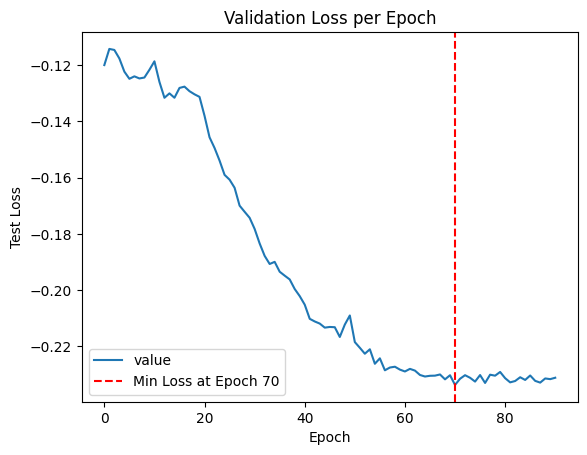

In [18]:
mean_test_loss = per_epoch_results.mean()['test']['loss']['network'] # tmp

# Plotting the mean test loss per epoch
mean_test_loss.plot()

# Finding the epoch with the minimum test loss
min_loss_epoch = mean_test_loss.idxmin()
min_loss_value = mean_test_loss.min()

# Adding a red vertical line at the epoch with minimum test loss
plt.axvline(x=min_loss_epoch, color='r', linestyle='--', label=f'Min Loss at Epoch {min_loss_epoch}')

# Adding some labels and title for clarity
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Show the plot
plt.show()

In [19]:
per_epoch_results.mean()['test']['loss']['network'].mean()

-0.19249028

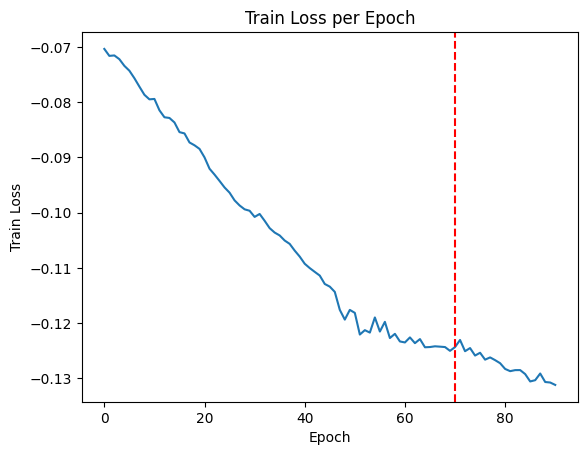

In [20]:
mean_train_loss = per_epoch_results.mean()['train']['loss']['network']

# Plotting the mean test loss per epoch
mean_train_loss.plot()



# Adding some labels and title for clarity
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss per Epoch')
plt.axvline(x=min_loss_epoch, color='r', linestyle='--', label=f'The best model {min_loss_epoch}')

# Show the plot
plt.show()

In [21]:
from deepdowmine.benchmarks import Benchmark, OneOverN, Random

benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'network': network
}

metrics = {
    'Sharpe': SharpeRatio(),
}


metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics
)

C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [22]:
metrics_table[metrics_table['benchmark'] == 'network']['value'].mean() / metrics_table[metrics_table['benchmark'] == '1overN']['value'].mean()

2.3857057

In [ ]:
metrics_table[metrics_table['benchmark'] == '1overN']['value'].mean()

-0.056892693

In [ ]:
metrics_table[metrics_table['benchmark'] == 'network']['value'].mean()

-0.15169235

In [ ]:
len(indices_test)

346

In [ ]:
one_over_n = metrics_table[metrics_table['benchmark'] == '1overN']['value']

In [ ]:
np.array(one_over_n)[indices_test]

IndexError: index 3111 is out of bounds for axis 0 with size 346

In [ ]:
# Filter the DataFrame for the two conditions
one_over_n = -metrics_table[metrics_table['benchmark'] == '1overN']['value']
network_res = -metrics_table[metrics_table['benchmark'] == 'network']['value']


x_axis = np.arange(len(one_over_n))  # This will create an array [0, 1, ..., n-1]

plt.figure(figsize=(10, 6))

# Plot each series on the same plot
plt.plot(x_axis, one_over_n, label='1overN', marker='o', linestyle='-')
plt.plot(x_axis, network_res, label='Network', marker='x', linestyle='-')

# Adding titles and labels
plt.title('Sharpe Ratio Comparison')
plt.xlabel('Index')
plt.ylabel('Sharpe Ratio')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
network_res

NameError: name 'network_res' is not defined

In [ ]:
metrics_table[metrics_table['benchmark'] == 'network']['value'].mean()

# Load the results

In [ ]:
network = LinearNetMine(1, lookback, n_assets, p=0.5)
network.load_state_dict(torch.load('linear_net_50x5_sharpe.pth'))

# Supplementary code

In [ ]:
# 1.363

In [ ]:
X.shape

In [ ]:
test_X = torch.tensor(X[[-1]], dtype=torch.float32)#(X[indices_train], dtype=torch.float32) #indices_train
test_X.shape

In [ ]:
def get_activation(name):
    # This function will return a hook function that stores the output in a dictionary
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Attach the hook to the covariance_layer, which precedes the channel_collapse_layer
activations = {}
hook = network.portfolio_opt_layer.register_forward_hook(get_activation('portfolio_opt_layer'))

# Now run your data through the network. This will store the output of the covariance_layer in activations
network(test_X)

# The output you're interested in is now stored in activations['covariance_layer_output']
input_to_channel_collapse = activations['portfolio_opt_layer']

# Don't forget to remove the hook when you're done to prevent memory leaks
hook.remove()

In [ ]:
input_to_channel_collapse.shape

In [ ]:
network(test_X).shape